In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats
import xgboost as xgb
from scipy.stats import norm
#from pyglmnet import GLM # Marco: need to understand how to install this
from sklearn.preprocessing import StandardScaler

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')


from pandas import ExcelWriter

<ipython-input-5-54373c810287>:9: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [ ]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [ ]:
#Distribution and skewness
def distskew(dataset,feature):
    fig = plt.figure()
    sns.distplot(dataset[feature], fit=norm);
    return("Skewness = ",skew(dataset[feature].dropna()))

In [ ]:
# Scatter plot
def scatplot(a,b):
    scatplotdata = pd.DataFrame({"x":a, "y":b})
    scatplotdata.plot(x = "x", y = "y", kind = "scatter")
    return()

<ipython-input-9-e877afb9892f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[feature], fit=norm);


('Skewness = ', 4.1179773827954875)

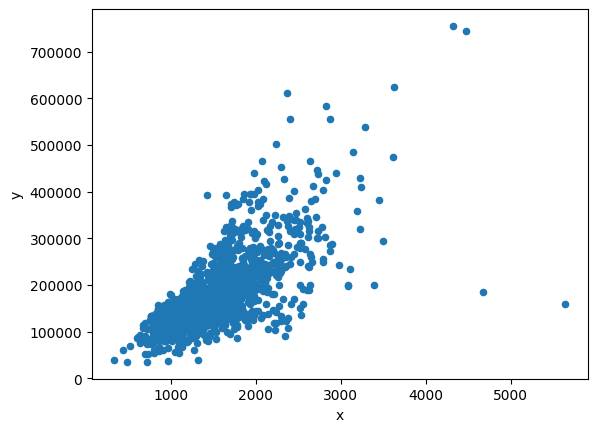

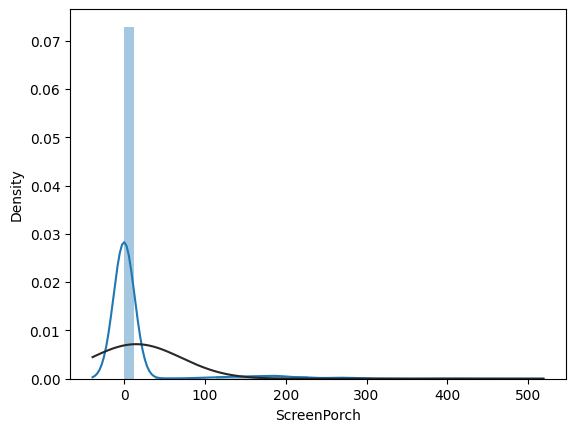

In [ ]:
scatplot(train["GrLivArea"],train["SalePrice"])
distskew(train,"ScreenPorch")

In [ ]:
#print(train.sort_values(by = 'GrLivArea', ascending = False)[:2])
print(train[train['GrLivArea'] > 4000].index)
#train = train.drop(train[train['Id'] == 1299].index)
#train = train.drop(train[train['Id'] == 524].index)

train = train.drop(train[train['GrLivArea'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF']> 6000].index)
#you can uncomment either to train, i have chosen the last one.

Index([523, 691, 1182, 1298], dtype='int64')


In [ ]:
# remove outlier for LotFrontage and mean imputation
train = train.drop(train[train['LotFrontage']>150].index)
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].mean())

In [ ]:
# Removing outlier for LotArea and transforming
train = train.drop(train[train['LotArea']>50001].index)

In [ ]:
all_data = pd.concat((train.loc[:,'Id':'SaleCondition'],
                      test.loc[:,'Id':'SaleCondition']))
print("\n train",train.shape)
print("\n test",test.shape)
print("\nall_data",all_data.shape)

#get the index of the numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

categorical_features = pd.DataFrame(all_data.describe(include = ['O'])).columns

prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
#prices.hist()

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])


 train (1439, 81)

 test (1459, 80)

all_data (2898, 80)


In [ ]:
# DATA CLEAN
#missing data
REMOVING_THRESH = 0.8

total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(10))
#MDV: remove the feature that has more than 10% of missing values
print("\n We are going to remove the below features : \n",missing_data[missing_data['Percent'] > REMOVING_THRESH])

all_data = all_data.drop(columns=(missing_data[missing_data['Percent'] > REMOVING_THRESH]).index)

print("\n After removed data the new dim of all_data are\n",all_data.shape)

             Total   Percent
PoolQC        2891  0.997585
MiscFeature   2795  0.964458
Alley         2701  0.932022
Fence         2329  0.803658
MasVnrType    1752  0.604555
FireplaceQu   1418  0.489303
LotFrontage    227  0.078330
GarageQual     158  0.054520
GarageCond     158  0.054520
GarageYrBlt    158  0.054520

 We are going to remove the below features : 
              Total   Percent
PoolQC        2891  0.997585
MiscFeature   2795  0.964458
Alley         2701  0.932022
Fence         2329  0.803658

 After removed data the new dim of all_data are
 (2898, 76)


<ipython-input-17-b236f638d4b2>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train['TotalBsmtSF'].loc[no_basement_houses_index] = train['GrLivArea'].loc[no_basement_houses_index]
<ipython-input-17-b236f638d4b2>:7: SettingWithCopyWarning:

('Skewness = ', 0.9776209704727413)

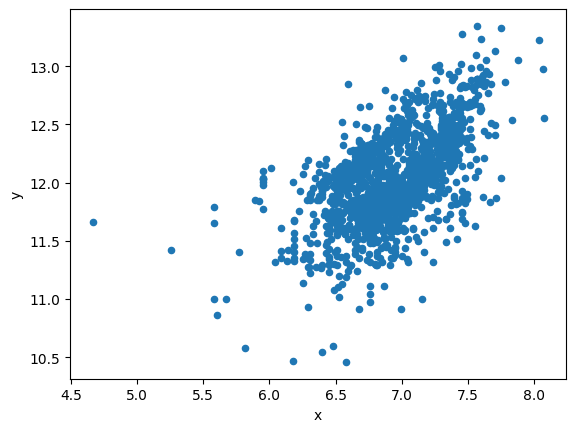

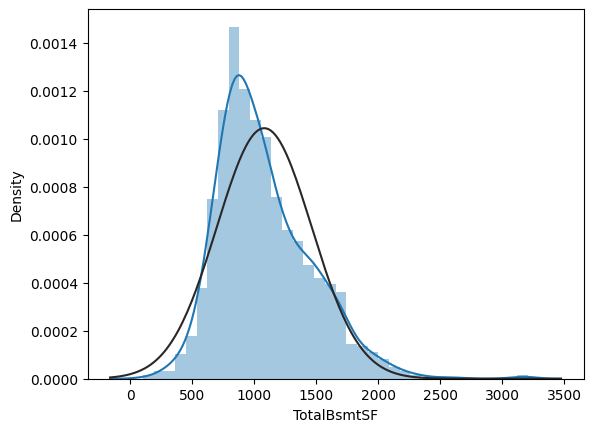

In [ ]:
#FEATURES ENGINEERING

#Marco: replace the TotalBsmtSF = 0 with the relative GrLivArea value of that house.
#improvment from skewness of -5.1 to 2.1

no_basement_houses_index = train[train['TotalBsmtSF']== 0].index
train['TotalBsmtSF'].loc[no_basement_houses_index] = train['GrLivArea'].loc[no_basement_houses_index]
#print(train['TotalBsmtSF'].loc[no_basement_houses_index])


#all_no_basement_houses_index= all_data[all_data['TotalBsmtSF']== 0].index
#all_data['TotalBsmtSF'].loc[all_no_basement_houses_index] = all_data['GrLivArea'].loc[all_no_basement_houses_index]


scatplot(np.log1p(train["TotalBsmtSF"]),train["SalePrice"])

distskew(train,"TotalBsmtSF")



In [ ]:
# Feature Engineering -Log transformation
all_data['LotArea']=np.log1p(all_data['LotArea'])
all_data["TotBsmtFin"] = all_data["BsmtFinSF1"] + all_data["BsmtFinSF2"]
train["TotBsmtFin"] = train["BsmtFinSF1"] + train["BsmtFinSF2"]

# Use axis=1 to specify that you want to drop columns
all_data = all_data.drop("BsmtFinSF1", axis=1)
all_data = all_data.drop("BsmtFinSF2", axis=1)

all_data["TotBath"] = all_data["FullBath"] + 0.5*all_data["HalfBath"] + all_data["BsmtFullBath"] + 0.5*all_data["BsmtHalfBath"]
train["TotBath"] = train["FullBath"] + 0.5*train["HalfBath"] + train["BsmtFullBath"] + 0.5*train["BsmtHalfBath"]

all_data = all_data.drop("FullBath", axis=1)
all_data = all_data.drop("HalfBath", axis=1)
all_data = all_data.drop("BsmtFullBath", axis=1)
all_data = all_data.drop("BsmtHalfBath", axis=1)


print("all_data dim:",all_data.shape)



all_data dim: (2898, 72)


In [ ]:
# Add the living areas and basement aread to create a new feature TotArea
all_data["TotArea"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
train["TotArea"] = train["GrLivArea"] + train["TotalBsmtSF"]


print("all_data dim: ",all_data.shape)
#print("\nX_test dim: ",X_test.shape)

all_data dim:  (2898, 73)


In [ ]:
#Marco 08052017 some new features:

all_data["HasFirePlace"] =all_data["Fireplaces"]>0
all_data["HasWoodDeck "] =all_data["WoodDeckSF"]>0

<ipython-input-21-2a8ae2af640d>:1: FutureWarning: The provided callable <function median at 0x7cf9d3624ca0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  quality_pivot = train.pivot_table(index='OverallQual',


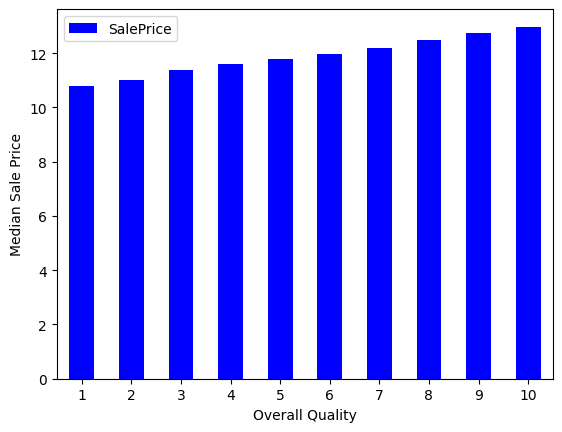

In [ ]:
quality_pivot = train.pivot_table(index='OverallQual',
                                    values='SalePrice',aggfunc=np.median)
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [ ]:
all_data['enc_street'] = pd.get_dummies(all_data.Street, drop_first=True)
print ('Encoded: \n')
print (all_data.enc_street.value_counts())

Encoded: 

enc_street
True     2887
False      11
Name: count, dtype: int64


In [ ]:
#LOG of skewed features
#Refresh the index of the numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#here i've changed the train[numeric_feats] with all_data[numeric_feats]
#because we are working on all_data and train is just a part of it.

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

#exctract the features with skewness higher than 75%
skewed_feats = skewed_feats[skewed_feats > 0.1]
skewed_feats = skewed_feats.index

#log transform skewed numeric features with skewness > 75%:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

train[skewed_feats] = np.log1p(train[skewed_feats])


print("all_data dim: ",all_data.shape)
#print("\nX_test dim: ",X_test.shape)

all_data dim:  (2898, 76)


In [ ]:
#Drop unnessessary features]all_data = all_data.drop("BsmtFinType1",1)
all_data = all_data.drop("2ndFlrSF", axis=1)
all_data = all_data.drop("BedroomAbvGr", axis=1)

all_data = all_data.drop("LowQualFinSF", axis=1)
all_data = all_data.drop("3SsnPorch", axis=1)
all_data = all_data.drop("PoolArea", axis=1)

#all_data = all_data.drop("GrLivArea",1)
#all_data = all_data.drop("TotalBsmtSF",1)
all_data = all_data.drop('Condition2', axis=1)

print("all_data dim: ",all_data.shape)
#print("\nX_test dim: ",X_test.shape)

all_data dim:  (2898, 70)


In [ ]:
#get dummies and drop dropna
dummies = pd.get_dummies(all_data)
all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.median())

In [ ]:
#Create the new X_train and X_test with all the selected features
# Normalize the features (this does not seem to help: increases error)
#all_data = all_data.apply(lambda x: x/np.sqrt(sum(x**2)))

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice#already log transformed
X_train['SalePrice'] = train.SalePrice

# save
X_train.to_csv("X_train_v2.csv")
X_test.to_csv("X_test_v2.csv")

X_train = X_train.drop("SalePrice", axis=1)
print("\nShape check\n train.shape: ",train.shape)
print(" X_Train dim: ",X_train.shape)
print("\n X_test dim: ",X_test.shape)

<ipython-input-26-86532623229f>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['SalePrice'] = train.SalePrice
<ipython-input-26-86532623229f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['SalePrice'] = train.SalePrice



Shape check
 train.shape:  (1439, 84)
 X_Train dim:  (1439, 261)

 X_test dim:  (1459, 261)


In [ ]:
print(X_train.Id)

0          1
1          2
2          3
3          4
4          5
        ... 
1455    1456
1456    1457
1457    1458
1458    1459
1459    1460
Name: Id, Length: 1439, dtype: int64


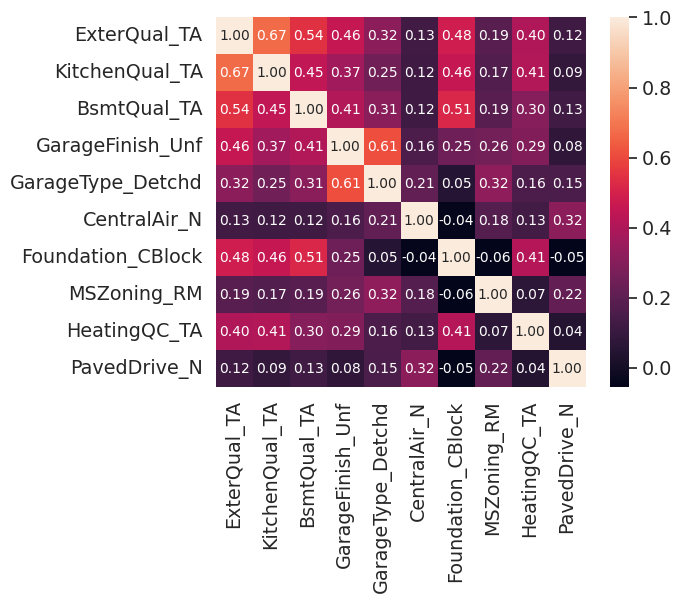

In [ ]:
#the analysis of the correlation between the new feature (from get_dummies) and the sale price
#post feature analysis
X_check=X_train.assign(SalePrice=train.SalePrice, index=X_train.index)
corrmat = X_check.corr()
#Correlation matrix with Log of Sale Price
k = 10 #number of variables for heatmap
#cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cols = corrmat.nsmallest(k, 'SalePrice')['SalePrice'].index

cm = np.corrcoef(X_check[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
#plt.show()

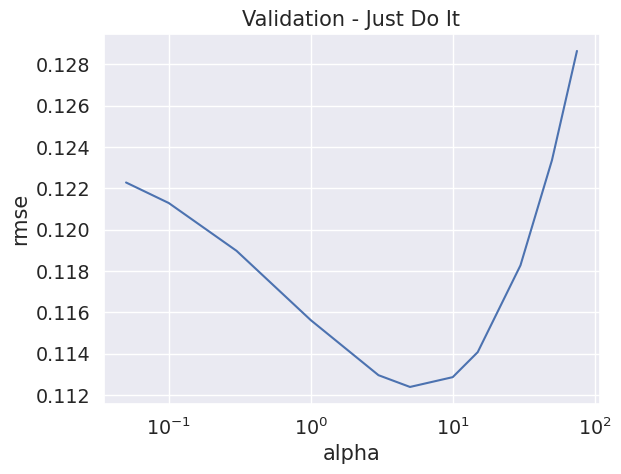

The min value of Ridge is  0.11239332952943401


In [ ]:
#fitting model
#first evaluation of the regular linear regression method:
#Ridge:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
           for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
#Marco: added log scale to have a better view of the minimum
plt.xscale("log")
plt.show()
print("The min value of Ridge is ",cv_ridge.min())

In [ ]:
#Choose the best alpha by taking the alpha that give the lowest rmse
best_alpha = 8
# Now fit Ridge model
model_ridge = Ridge(alpha = best_alpha).fit(X_train, y)

The min value of Lasso is  0.10956381952729796
Lasso picked 96 variables and eliminated the other 165 variables


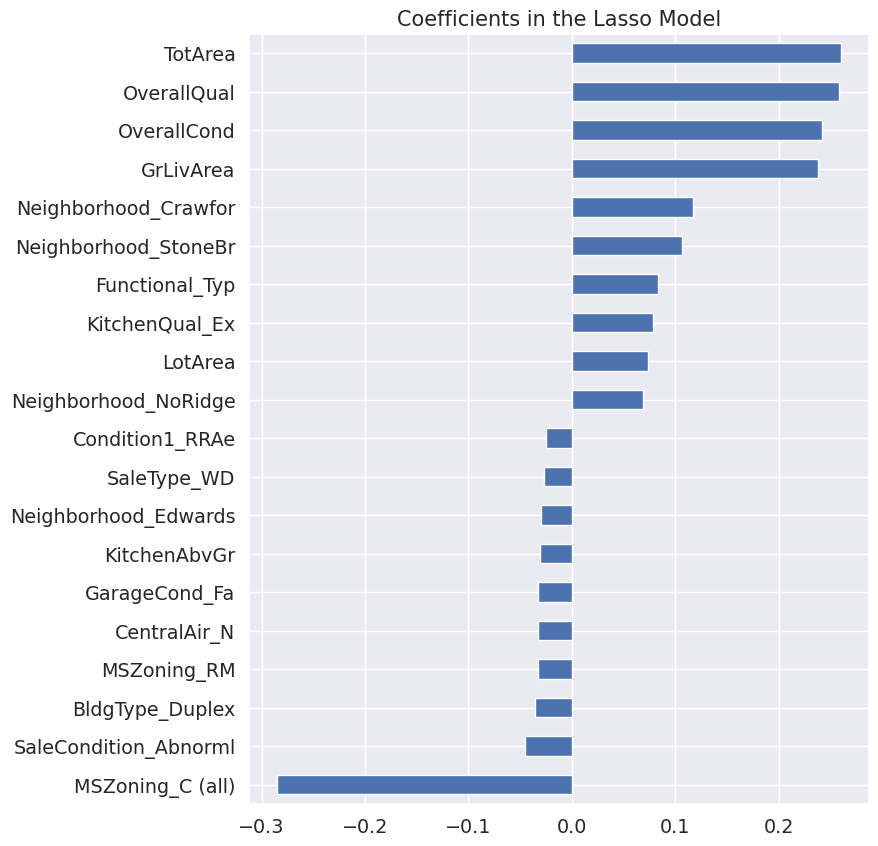

In [ ]:
#Lasso:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print("The min value of Lasso is ",rmse_cv(model_lasso).mean())


#Lasso choose performs also feature selection

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

#Let's look to the most important coefficients:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()


#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds_log = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
#let's return to "original" value from the log:
preds_val = np.expm1(preds_log)



preds_log["residuals"] = preds_log["true"] - preds_log["preds"]



#preds_log.plot(x = "preds", y = "true",kind = "scatter")
#plt.title('Log Value ')
#plt.show()

#
#preds_val["residuals"] = preds_val["true"] - preds_val["preds"]
#preds_val.plot(x = "preds", y = "residuals",kind = "scatter")
#plt.title('Original Value in $')
#plt.show()

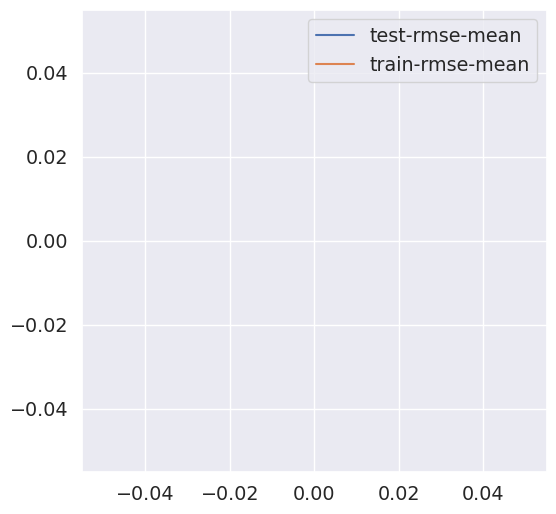

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Let's add an xgboost model to our linear model to see
#if we can improve our score:

#y = preds_log["residuals"]

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.show()

#the params were tuned using xgb.cv
model_xgb = xgb.XGBRegressor(n_estimators=300, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

In [ ]:
#model_glm = GLM(distr='gaussian')
scaler1 = StandardScaler().fit(X_train)
scaler2 = StandardScaler().fit(X_test)
#model_glm.fit(scaler1.transform(X_train), y)

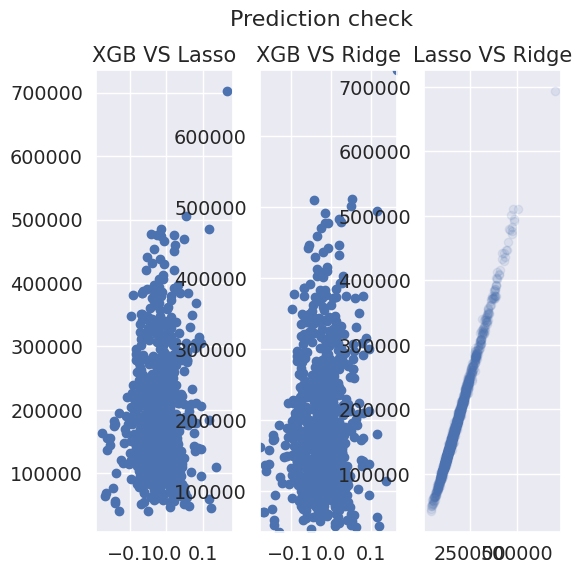

In [ ]:
from matplotlib import gridspec

xgb_preds = np.expm1(model_xgb.predict(X_test))
ridge_preds = np.expm1(model_ridge.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

#Marco: I still don't have the glm available on my Jupyter env
#glm_preds = np.expm1(model_glm.predict(scaler2.transform(X_test)))
predictions_lasso = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
#predictions.plot(x = "xgb", y = "lasso", kind = "scatter")
#plt.show()

predictions_ridge = pd.DataFrame({"xgb":xgb_preds, "ridge":ridge_preds})

lasso_vs_ridge = pd.DataFrame({"lasso":lasso_preds, "ridge":ridge_preds})

fig = plt.figure()


fig.suptitle("Prediction check", fontsize=16)
# Corrected subplot call: Pass 1, 3, 1 as separate arguments
ax = plt.subplot(1, 3, 1)
ax.set_title("XGB VS Lasso")
ax.scatter(xgb_preds,lasso_preds)

#axes = plt.gca()
#ax.set_xlim([xmin,xmax])
#axes.set_ylim([ymin,ymax])

# Corrected subplot call: Pass 1, 3, 2 as separate arguments
ax = plt.subplot(1, 3, 2)
ax.set_title("XGB VS Ridge")
ax.scatter(xgb_preds,ridge_preds)
ax.autoscale(tight=True)

# Corrected subplot call: Pass 1, 3, 3 as separate arguments
ax = plt.subplot(1, 3, 3)
ax.set_title("Lasso VS Ridge")
ax.scatter(lasso_preds,ridge_preds,alpha=.1)

plt.show()

In [ ]:
#preds = 0.30*lasso_preds + 0.30*ridge_preds + 0.40*xgb_preds
preds = 0.60*lasso_preds + 0.40*xgb_preds
#preds = lasso_preds
#preds = ridge_preds
#preds= xgb_preds

solution = pd.DataFrame({"SalePrice":preds,"id":test.Id})